# Extracción de Datos 

Este notebook se desarrolló principalmente porque no se tenían los recursos de memoria para almacenar localmente la totalidad de las imágenes del dataset, que consta de alrededor de un millón de cortes DICOM. Por esta razón, se optó por descomprimir únicamente aquellas imágenes relevantes para el análisis. En el caso de pacientes con aneurismas, se extrajo el corte donde se localiza la patología junto con los cortes anterior y posterior, con el fin de proporcionar mayor contexto espacial al modelo, dado que cada imagen corresponde a una fracción de una secuencia volumétrica y no siempre contiene la estructura cerebral completa. Estos tres cortes se combinaron en una única imagen de tres canales (RGB). Para los pacientes sin aneurismas, se seleccionaron cortes representativos de manera aleatoria siguiendo el mismo criterio de preprocesamiento, para tener un conjunto de datos completo.

In [ ]:
# Se importan las librerías necesarias para el procesamiento de datos, visualización y manejo de archivos.
# pandas y numpy para manipulación de datos.
# seaborn y matplotlib para gráficos.
# zipfile, os e io para gestión de archivos comprimidos y rutas.
# pydicom para lectura de imágenes médicas DICOM.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import zipfile
import os
import pydicom
import matplotlib.pyplot as plt
import math
import io


## Extracción de imágenes de pacientes Enfermos

In [ ]:
# Se carga el dataset principal filtrado por modalidades MRA y CTA.
data=pd.read_csv('train_MRA_CTA.csv')
data

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,58,Male,CTA,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,71,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,48,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,1.2.826.0.1.3680043.8.498.99892990973227842737...,73,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3056,1.2.826.0.1.3680043.8.498.99895756899933461331...,39,Female,CTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3057,1.2.826.0.1.3680043.8.498.99920680741054836990...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3058,1.2.826.0.1.3680043.8.498.99953513260518059135...,44,Female,CTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Se carga el dataset de localizadores que contiene las coordenadas de los aneurismas.
datalocalizers=pd.read_csv('train_localizers_MRA_CTA.csv')
datalocalizers

,SeriesInstanceUID,SOPInstanceUID,coordinates,location
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery
...,...,...,...,...
1876,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.10885430363476327277...,"{'x': 204.2324966974901, 'y': 216.4332892998679}",Right Middle Cerebral Artery
1877,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.75978746530527925899...,"{'x': 153.42160206895431, 'y': 188.45547208042...",Right Middle Cerebral Artery
1878,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.88559536225248716051...,"{'x': 364.01486988847586, 'y': 195.33085501858...",Left Middle Cerebral Artery
1879,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.41770479778255354615...,"{'x': 177.48698884758363, 'y': 210.55762081784...",Right Middle Cerebral Artery


In [ ]:
# Se definen las rutas del archivo ZIP de origen y la carpeta base donde se extraerán las imágenes de aneurismas.
zip_path = "/home/dayana-henao/Escritorio/rsna-intracranial-aneurysm-detection.zip"
output_base_path = "/home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_aneurismas"

In [ ]:
def extraer_trio_rgb_paciente(zip_ref, patient_uid, target_sop_uids, output_folder):
    """
    Extrae tríos de imágenes (anterior, central, siguiente) para formar canales RGB centrados en el aneurisma.
    """
    # Se filtran los archivos DICOM correspondientes al paciente dentro del ZIP.
    patient_files = [f for f in zip_ref.namelist() if patient_uid in f and f.endswith('.dcm')]
    if not patient_files:
        print(f"No se encontraron archivos para el paciente {patient_uid}")
        return

    # Se leen los metadatos de cada archivo para obtener el orden anatómico (InstanceNumber).
    metadata_list = []
    for filename in patient_files:
        try:
            with zip_ref.open(filename) as f:
                dcm_bytes = io.BytesIO(f.read())
                ds = pydicom.dcmread(dcm_bytes, stop_before_pixels=True)
                
                # Se verifica que las dimensiones de la imagen sean estrictamente 512x512.
                if ds.Rows != 512 or ds.Columns != 512:
                    continue

                inst_num = int(ds.InstanceNumber) if hasattr(ds, 'InstanceNumber') else 0
                
                metadata_list.append({
                    'filename': filename,
                    'SOPInstanceUID': ds.SOPInstanceUID,
                    'InstanceNumber': inst_num
                })
        except Exception as e:
            # Se ignoran archivos corruptos o ilegibles.
            continue

    # Se ordenan los metadatos por posición anatómica.
    metadata_list.sort(key=lambda x: x['InstanceNumber'])

    # Se crea un índice para búsqueda rápida por SOPInstanceUID.
    sop_to_index = {item['SOPInstanceUID']: i for i, item in enumerate(metadata_list)}

    # Se crea la carpeta de destino para el paciente.
    patient_folder = os.path.join(output_folder, patient_uid)
    os.makedirs(patient_folder, exist_ok=True)

    # Se procesan los cortes objetivo donde se ha identificado un aneurisma.
    processed_indices = set()

    for target_sop in target_sop_uids:
        if target_sop not in sop_to_index:
            print(f"SOP {target_sop} no encontrado en la secuencia del paciente (o descartado por tamaño).")
            continue
            
        target_idx = sop_to_index[target_sop]
        
        # Se seleccionan los índices para los canales R, G y B (anterior, central, siguiente).
        indices_to_extract = [
            max(0, target_idx - 1),       # Anterior (Canal R)
            target_idx,                   # Central (Canal G - Aneurisma)
            min(len(metadata_list)-1, target_idx + 1) # Siguiente (Canal B)
        ]
        
        # Se extraen físicamente los archivos seleccionados del ZIP.
        for idx in indices_to_extract:
            if idx in processed_indices:
                continue 
                
            file_info = metadata_list[idx]
            src_filename = file_info['filename']
            dst_path = os.path.join(patient_folder, os.path.basename(src_filename))
            
            with zip_ref.open(src_filename) as source, open(dst_path, "wb") as target:
                target.write(source.read())
            
            processed_indices.add(idx)

In [ ]:
# Se agrupan los localizadores por paciente (SeriesInstanceUID) para obtener la lista de imágenes con aneurisma (SOPInstanceUID) de cada uno.
grouped_patients = datalocalizers.groupby('SeriesInstanceUID')['SOPInstanceUID'].apply(list)
grouped_patients

SeriesInstanceUID
1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317    [1.2.826.0.1.3680043.8.498.1077532934817490219...
1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831    [1.2.826.0.1.3680043.8.498.5386840977423728328...
1.2.826.0.1.3680043.8.498.10023411164590664678534044036963716636    [1.2.826.0.1.3680043.8.498.2418653534474488647...
1.2.826.0.1.3680043.8.498.10030095840917973694487307992374923817    [1.2.826.0.1.3680043.8.498.7521708484185421454...
1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557    [1.2.826.0.1.3680043.8.498.7123710473145236858...
                                                                                          ...                        
1.2.826.0.1.3680043.8.498.99683289635797559819400829874963008274    [1.2.826.0.1.3680043.8.498.1549479380828757950...
1.2.826.0.1.3680043.8.498.99800061424469215274400822361248888410    [1.2.826.0.1.3680043.8.498.1098819586468176363...
1.2.826.0.1.3680043.8.498.998876755543

In [ ]:
# Se abre el archivo ZIP y se itera sobre cada paciente agrupado para ejecutar la extracción de imágenes.
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Optimización opcional: Leer la lista de archivos UNA sola vez para no hacerlo por cada paciente
    all_files = zip_ref.namelist()
    
    for i, (patient_uid, target_sops) in enumerate(grouped_patients.items()):
        # Se imprime el progreso cada 100 pacientes.
        if i % 100 == 0:
            print(f"Procesando paciente {i+1}/{len(grouped_patients)}: {patient_uid}")
        
        extraer_trio_rgb_paciente(zip_ref, patient_uid, target_sops, output_base_path)

Procesando paciente 1/1528: 1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317
SOP 1.2.826.0.1.3680043.8.498.63062558671948377310688873437936911318 no encontrado en la secuencia del paciente (o descartado por tamaño).
SOP 1.2.826.0.1.3680043.8.498.63062558671948377310688873437936911318 no encontrado en la secuencia del paciente (o descartado por tamaño).
SOP 1.2.826.0.1.3680043.8.498.81558459046210612235854667966367774775 no encontrado en la secuencia del paciente (o descartado por tamaño).
SOP 1.2.826.0.1.3680043.8.498.81558459046210612235854667966367774775 no encontrado en la secuencia del paciente (o descartado por tamaño).
SOP 1.2.826.0.1.3680043.8.498.56762390394513915690797603539671199134 no encontrado en la secuencia del paciente (o descartado por tamaño).
SOP 1.2.826.0.1.3680043.8.498.56762390394513915690797603539671199134 no encontrado en la secuencia del paciente (o descartado por tamaño).
SOP 1.2.826.0.1.3680043.8.498.85361000133142729080280080955640119924 no e

In [ ]:
# Se eliminan las carpetas que quedaron vacías después del proceso de extracción (por ejemplo, si todas las imágenes fueron descartadas por tamaño).
for root, dirs, files in os.walk(output_base_path, topdown=False):
    for name in dirs:
        dir_path = os.path.join(root, name)
        if not os.listdir(dir_path):  # Si la carpeta está vacía
            os.rmdir(dir_path)
            print(f"Carpeta vacía eliminada: {dir_path}")

Carpeta vacía eliminada: /home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_aneurismas/1.2.826.0.1.3680043.8.498.86738851244916630398579781113619279737
Carpeta vacía eliminada: /home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_aneurismas/1.2.826.0.1.3680043.8.498.56110291851048020997480352359185668962
Carpeta vacía eliminada: /home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_aneurismas/1.2.826.0.1.3680043.8.498.12748716782089334402948609986195561053
Carpeta vacía eliminada: /home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_aneurismas/1.2.826.0.1.3680043.8.498.97856025906265309755009045740425954643
Carpeta vacía eliminada: /home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_aneurismas/1.2.826.0.1.3680043.8.498.71887527501290982095123629465022428930
Carpeta vacía eliminada: /home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_aneurismas/1.2.826.0

In [ ]:
# Se listan las carpetas de pacientes que contienen imágenes válidas y se crea un DataFrame con estos identificadores.
remaining_patients = [d for d in os.listdir(output_base_path) if os.path.isdir(os.path.join(output_base_path, d))]

# Crear un DataFrame
df_remaining = pd.DataFrame(remaining_patients, columns=['SeriesInstanceUID'])
df_remaining

,SeriesInstanceUID
0,1.2.826.0.1.3680043.8.498.11855540419252203873...
1,1.2.826.0.1.3680043.8.498.90846479216555688983...
2,1.2.826.0.1.3680043.8.498.59130959901886851208...
3,1.2.826.0.1.3680043.8.498.68112874432587640364...
4,1.2.826.0.1.3680043.8.498.75798029534455454939...
...,...
1204,1.2.826.0.1.3680043.8.498.22822091412111379761...
1205,1.2.826.0.1.3680043.8.498.68709340002397343932...
1206,1.2.826.0.1.3680043.8.498.30606607816870370677...
1207,1.2.826.0.1.3680043.8.498.15840650969297006755...


In [ ]:
# Se guarda la lista de pacientes con imágenes válidas en un archivo CSV.
csv_output_path = 'pacientes_con_imagenes.csv'
df_remaining.to_csv(csv_output_path, index=False)

In [ ]:
# Se filtra el dataset de localizadores original para mantener solo los registros de los pacientes que tienen imágenes extraídas válidas.
df_localizers = pd.read_csv('train_localizers_MRA_CTA.csv')
df = df_localizers[df_localizers['SeriesInstanceUID'].isin(df_remaining['SeriesInstanceUID'])].copy()
df.to_csv('localizers_pacientes_con_imagenes.csv', index=False)

In [ ]:
# Se visualiza el DataFrame de localizadores filtrado.
df

,SeriesInstanceUID,SOPInstanceUID,coordinates,location
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery
...,...,...,...,...
1876,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.10885430363476327277...,"{'x': 204.2324966974901, 'y': 216.4332892998679}",Right Middle Cerebral Artery
1877,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.75978746530527925899...,"{'x': 153.42160206895431, 'y': 188.45547208042...",Right Middle Cerebral Artery
1878,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.88559536225248716051...,"{'x': 364.01486988847586, 'y': 195.33085501858...",Left Middle Cerebral Artery
1879,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.41770479778255354615...,"{'x': 177.48698884758363, 'y': 210.55762081784...",Right Middle Cerebral Artery


In [ ]:
import pandas as pd
import numpy as np
import os
import pydicom
import ast

# Se definen las rutas para leer las imágenes extraídas y guardar los archivos procesados (.npy).
base_img_path = "/home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_aneurismas/"
output_npy_path = "/home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_procesados_npy/"
os.makedirs(output_npy_path, exist_ok=True)

df_localizers = pd.read_csv('localizers_pacientes_con_imagenes.csv')
dataset_rows = []

def normalize_pixels(img):
    """Normaliza una imagen DICOM a rango 0-255 (uint8)"""
    img = img.astype(float)
    if img.max() == img.min():
        return np.zeros_like(img, dtype=np.uint8)
    img = (img - img.min()) / (img.max() - img.min()) * 255.0
    return img.astype(np.uint8)

# Se agrupan los localizadores por paciente para procesar sus imágenes en bloque.
grouped = df_localizers.groupby('SeriesInstanceUID')

print(f"Procesando píxeles de {len(grouped)} pacientes...")

for patient_uid, group in grouped:
    patient_folder = os.path.join(base_img_path, patient_uid)
    
    if not os.path.exists(patient_folder):
        continue
        
    # Se mapea el número de instancia al nombre de archivo para reconstruir la secuencia.
    map_instance_to_file = {}
    map_sop_to_instance = {}
    
    files = [f for f in os.listdir(patient_folder) if f.endswith('.dcm')]
    for f in files:
        try:
            ds = pydicom.dcmread(os.path.join(patient_folder, f), stop_before_pixels=True)
            inst_num = int(ds.InstanceNumber)
            map_instance_to_file[inst_num] = f
            map_sop_to_instance[ds.SOPInstanceUID] = inst_num
        except:
            continue
            
    # Se procesa cada aneurisma identificado en el grupo.
    for _, row in group.iterrows():
        sop_central = row['SOPInstanceUID']
        
        if sop_central not in map_sop_to_instance:
            continue
            
        central_idx = map_sop_to_instance[sop_central]
        
        # Se identifican los archivos correspondientes a los canales R, G y B.
        file_central = map_instance_to_file[central_idx]
        file_prev = map_instance_to_file.get(central_idx - 1, file_central)
        file_next = map_instance_to_file.get(central_idx + 1, file_central)
        
        try:
            
            # Se leen las matrices de píxeles de los 3 archivos DICOM.
            dcm_r = pydicom.dcmread(os.path.join(patient_folder, file_prev)).pixel_array
            dcm_g = pydicom.dcmread(os.path.join(patient_folder, file_central)).pixel_array
            dcm_b = pydicom.dcmread(os.path.join(patient_folder, file_next)).pixel_array
            
            # Se normalizan los valores de píxeles al rango 0-255.
            img_r = normalize_pixels(dcm_r)
            img_g = normalize_pixels(dcm_g)
            img_b = normalize_pixels(dcm_b)
            
            # Se apilan los canales para formar una imagen RGB (Alto, Ancho, 3).
            rgb_image = np.dstack((img_r, img_g, img_b))
            
            # Se guarda la matriz resultante en formato .npy para un acceso rápido durante el entrenamiento.
            npy_filename = f"{sop_central}.npy"
            npy_full_path = os.path.join(output_npy_path, npy_filename)
            
            np.save(npy_full_path, rgb_image)
            
            # Se extraen las coordenadas del aneurisma.
            coords = ast.literal_eval(row['coordinates'])
            
            # Se añade la información al dataset final.
            dataset_rows.append({
                'SeriesInstanceUID': patient_uid,
                'SOPInstanceUID': sop_central,
                'npy_path': npy_filename, # Referencia al archivo de píxeles
                'x': coords['x'],
                'y': coords['y'],
                'label': 1
            })
            
        except Exception as e:
            print(f"Error procesando imagen {sop_central}: {e}")

# Se guarda el dataset procesado en un archivo CSV.
df_train_npy = pd.DataFrame(dataset_rows)
df_train_npy.to_csv('dataset_train_npy.csv', index=False)

Procesando píxeles de 1209 pacientes...


/home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/venv/lib/python3.12/site-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(


In [ ]:
# Se carga el dataset de entrenamiento procesado para verificar su contenido.
df_train_npy=pd.read_csv('dataset_train_npy.csv')

In [ ]:
# Se visualiza el DataFrame procesado.
df_train_npy

,SeriesInstanceUID,SOPInstanceUID,npy_path,x,y,label
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,1.2.826.0.1.3680043.8.498.10775329348174902199...,258.362119,261.359900,1
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,1.2.826.0.1.3680043.8.498.53868409774237283281...,194.872531,178.326750,1
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,1.2.826.0.1.3680043.8.498.24186535344744886473...,189.239799,209.191849,1
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,1.2.826.0.1.3680043.8.498.75217084841854214544...,208.280505,229.789621,1
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,1.2.826.0.1.3680043.8.498.71237104731452368587...,249.867456,220.623045,1
...,...,...,...,...,...,...
1493,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.10885430363476327277...,1.2.826.0.1.3680043.8.498.10885430363476327277...,204.232497,216.433289,1
1494,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.75978746530527925899...,1.2.826.0.1.3680043.8.498.75978746530527925899...,153.421602,188.455472,1
1495,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.88559536225248716051...,1.2.826.0.1.3680043.8.498.88559536225248716051...,364.014870,195.330855,1
1496,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.41770479778255354615...,1.2.826.0.1.3680043.8.498.41770479778255354615...,177.486989,210.557621,1


In [ ]:
# Se realiza una prueba de carga de un archivo .npy para verificar dimensiones.
fila = df_train_npy.iloc[1]
ruta_npy = os.path.join(output_npy_path, fila['npy_path'])

# Cargar píxeles instantáneamente
imagen_rgb = np.load(ruta_npy) 

print(imagen_rgb.shape)

(512, 512, 3)


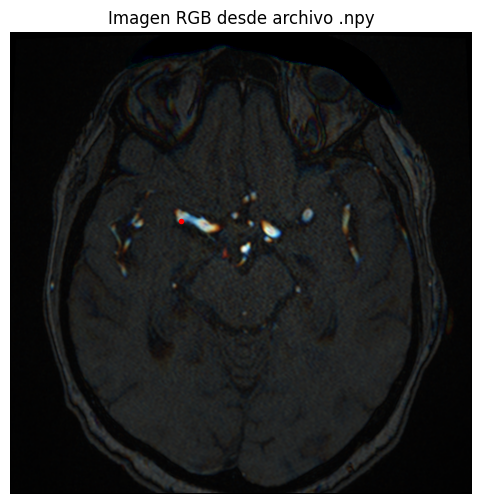

In [ ]:
# Se carga y visualiza una imagen procesada junto con la ubicación del aneurisma (punto rojo).
fila = df_train_npy.iloc[2]
ruta_npy = os.path.join(output_npy_path, fila['npy_path'])

imagen_rgb = np.load(ruta_npy)

# Graficar
plt.figure(figsize=(6,6))
plt.imshow(imagen_rgb)
plt.plot(df_train_npy['x'][2], df_train_npy['y'][2], 'r.')  # Punto rojo en las coordenadas del aneurisma
plt.axis('off')
plt.title("Imagen RGB desde archivo .npy")
plt.show()

## Extracción de Imágenes de Pacientes Sanos 

In [ ]:
# Se filtran los pacientes sanos (sin aneurisma) del dataset original y se guardan en un archivo CSV separado.
healthy_patients=data[data['Aneurysm Present']==0].to_csv('pacientes_sanos.csv', index=False)

In [ ]:
# Se carga el dataset de pacientes sanos.
healthy_data=pd.read_csv('pacientes_sanos.csv')
healthy_data

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10009383108068795488...,71,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.10012790035410518400...,48,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10014757658335054766...,53,Female,CTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,1.2.826.0.1.3680043.8.498.99686187674549713356...,66,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1528,1.2.826.0.1.3680043.8.498.99892990973227842737...,73,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1529,1.2.826.0.1.3680043.8.498.99895756899933461331...,39,Female,CTA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1530,1.2.826.0.1.3680043.8.498.99920680741054836990...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import zipfile
import pandas as pd
import random # Usamos la librería estándar, NO numpy.random
import io
import os
import pydicom

# Configuración de rutas y parámetros para la extracción de muestras sanas.
zip_path = "/home/dayana-henao/Escritorio/rsna-intracranial-aneurysm-detection.zip"
output_sanos_path = "/home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_sanos"
samples_per_patient = 1

def extraer_trio_rgb_sanos_aleatorio(zip_ref, patient_uid, output_folder, n_samples=2):
    """
    Extrae aleatoriamente tríos de imágenes de pacientes sanos para generar muestras negativas.
    """
    # Se listan los archivos del paciente.
    patient_files = [f for f in zip_ref.namelist() if patient_uid in f and f.endswith('.dcm')]
    if len(patient_files) < 10: 
        return []

    # Se leen los metadatos y se filtran imágenes que no sean de 512x512.
    metadata_list = []
    for filename in patient_files:
        try:
            with zip_ref.open(filename) as f:
                dcm_bytes = io.BytesIO(f.read())
                ds = pydicom.dcmread(dcm_bytes, stop_before_pixels=True)
                
                # Verificar dimensiones 512x512
                if ds.Rows != 512 or ds.Columns != 512:
                    continue

                inst_num = int(ds.InstanceNumber) if hasattr(ds, 'InstanceNumber') else 0
                
                metadata_list.append({
                    'filename': filename,
                    'SOPInstanceUID': ds.SOPInstanceUID,
                    'InstanceNumber': inst_num
                })
        except:
            continue

    metadata_list.sort(key=lambda x: x['InstanceNumber'])
    
    if not metadata_list:
        return []

    # Se define un margen para evitar seleccionar imágenes de los extremos del escaneo (inicio/fin).
    margin = int(len(metadata_list) * 0.1)
    margin = max(1, margin)
    
    if len(metadata_list) <= 2 * margin:
         valid_range = range(0, len(metadata_list))
    else:
         valid_range = range(margin, len(metadata_list) - margin)

    if len(valid_range) == 0:
        return []

    # Se seleccionan índices aleatorios dentro del rango válido.
    if len(valid_range) < n_samples:
        selected_indices = list(valid_range)
    else:
        selected_indices = random.sample(valid_range, n_samples)

    extracted_info = []
    patient_folder = os.path.join(output_folder, patient_uid)
    os.makedirs(patient_folder, exist_ok=True)

    # Se extraen las imágenes seleccionadas y sus vecinas.
    for target_idx in selected_indices:
        indices_to_extract = [target_idx - 1, target_idx, target_idx + 1]
        
        if any(idx < 0 or idx >= len(metadata_list) for idx in indices_to_extract):
            continue
            
        for idx in indices_to_extract:
            file_info = metadata_list[idx]
            src_filename = file_info['filename']
            dst_path = os.path.join(patient_folder, os.path.basename(src_filename))
            
            if not os.path.exists(dst_path):
                with zip_ref.open(src_filename) as source, open(dst_path, "wb") as target:
                    target.write(source.read())
        
        central_item = metadata_list[target_idx]
        extracted_info.append({
            'SeriesInstanceUID': patient_uid,
            'SOPInstanceUID': central_item['SOPInstanceUID'],
            'label': 0
        })
        
    return extracted_info


healthy_metadata = []

# Se obtiene la lista de pacientes sanos únicos.
patients_list = healthy_data['SeriesInstanceUID'].unique()

# Se ejecuta la extracción aleatoria para los pacientes sanos.
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for i, patient_uid in enumerate(patients_list):
        if i % 100 == 0:
            print(f"Procesando sano {i+1}/{len(patients_list)}: {patient_uid}")
            
        info = extraer_trio_rgb_sanos_aleatorio(zip_ref, patient_uid, output_sanos_path, samples_per_patient)
        healthy_metadata.extend(info)

Procesando sano 1/1532: 1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647
Procesando sano 11/1532: 1.2.826.0.1.3680043.8.498.10046318991957083423208748012349179640
Procesando sano 11/1532: 1.2.826.0.1.3680043.8.498.10046318991957083423208748012349179640
Procesando sano 21/1532: 1.2.826.0.1.3680043.8.498.10126204714343951399034097831014403155
Procesando sano 21/1532: 1.2.826.0.1.3680043.8.498.10126204714343951399034097831014403155
Procesando sano 31/1532: 1.2.826.0.1.3680043.8.498.10240701911188793595728082556212433173
Procesando sano 31/1532: 1.2.826.0.1.3680043.8.498.10240701911188793595728082556212433173
Procesando sano 41/1532: 1.2.826.0.1.3680043.8.498.10296102422523588648003548596991595445
Procesando sano 41/1532: 1.2.826.0.1.3680043.8.498.10296102422523588648003548596991595445
Procesando sano 51/1532: 1.2.826.0.1.3680043.8.498.10368139067683482062463559717739182190
Procesando sano 51/1532: 1.2.826.0.1.3680043.8.498.10368139067683482062463559717739182190
Procesando 

In [ ]:
# Se guarda la metadata de las muestras sanas extraídas en un archivo CSV.
pd.DataFrame(healthy_metadata).to_csv('healthy_samples_metadata.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import os
import pydicom

# Se definen las rutas para procesar las imágenes de pacientes sanos.
base_sanos_path = "/home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_sanos"
output_npy_path = "/home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_procesados_npy/" 
os.makedirs(output_npy_path, exist_ok=True)

# Se lee la metadata de las muestras sanas.
df_healthy_meta = pd.read_csv('healthy_samples_metadata.csv')
dataset_rows_sanos = []

def normalize_pixels(img):
    """Normaliza una imagen DICOM a rango 0-255 (uint8)"""
    img = img.astype(float)
    if img.max() == img.min():
        return np.zeros_like(img, dtype=np.uint8)
    img = (img - img.min()) / (img.max() - img.min()) * 255.0
    return img.astype(np.uint8)

# Se agrupan las muestras sanas por paciente.
grouped = df_healthy_meta.groupby('SeriesInstanceUID')

print(f"Procesando píxeles de {len(grouped)} pacientes sanos...")

for patient_uid, group in grouped:
    patient_folder = os.path.join(base_sanos_path, patient_uid)
    
    if not os.path.exists(patient_folder):
        print(f"Advertencia: No se encuentra la carpeta del paciente {patient_uid} en {base_sanos_path}")
        continue
        
    # Mapeo de InstanceNumber a archivo.
    map_instance_to_file = {}
    map_sop_to_instance = {}
    
    files = [f for f in os.listdir(patient_folder) if f.endswith('.dcm')]
    for f in files:
        try:
            ds = pydicom.dcmread(os.path.join(patient_folder, f), stop_before_pixels=True)
            inst_num = int(ds.InstanceNumber)
            map_instance_to_file[inst_num] = f
            map_sop_to_instance[ds.SOPInstanceUID] = inst_num
        except:
            continue
            
    # Procesamiento de cada muestra seleccionada.
    for _, row in group.iterrows():
        sop_central = row['SOPInstanceUID']
        
        if sop_central not in map_sop_to_instance:
            continue
            
        central_idx = map_sop_to_instance[sop_central]
        
        # Identificación de archivos para canales RGB.
        file_central = map_instance_to_file[central_idx]
        file_prev = map_instance_to_file.get(central_idx - 1, file_central)
        file_next = map_instance_to_file.get(central_idx + 1, file_central)
        
        try:
            # Lectura de DICOMs.
            dcm_r = pydicom.dcmread(os.path.join(patient_folder, file_prev)).pixel_array
            dcm_g = pydicom.dcmread(os.path.join(patient_folder, file_central)).pixel_array
            dcm_b = pydicom.dcmread(os.path.join(patient_folder, file_next)).pixel_array
            
            # Normalización.
            img_r = normalize_pixels(dcm_r)
            img_g = normalize_pixels(dcm_g)
            img_b = normalize_pixels(dcm_b)
            
            # Apilado RGB.
            rgb_image = np.dstack((img_r, img_g, img_b))
            
            # Guardado en .npy.
            npy_filename = f"{sop_central}.npy"
            npy_full_path = os.path.join(output_npy_path, npy_filename)
            
            np.save(npy_full_path, rgb_image)
            
            # Registro en el dataset (etiqueta 0 para sanos, coordenadas -1).
            dataset_rows_sanos.append({
                'SeriesInstanceUID': patient_uid,
                'SOPInstanceUID': sop_central,
                'npy_path': npy_filename,
                'x': -1, 
                'y': -1,
                'label': 0
            })
            
        except Exception as e:
            print(f"Error procesando sano {sop_central}: {e}")

Procesando píxeles de 1149 pacientes sanos...


In [ ]:
# Se guarda el dataset final de muestras sanas procesadas.
df_sanos_npy = pd.DataFrame(dataset_rows_sanos)
df_sanos_npy.to_csv('dataset_sanos_npy.csv', index=False)

In [ ]:
# Se carga el dataset de sanos para verificación.
df_sanos_npy=pd.read_csv('dataset_sanos_npy.csv')

In [ ]:
# Se visualiza el DataFrame de sanos.
df_sanos_npy

,SeriesInstanceUID,SOPInstanceUID,npy_path,x,y,label
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,1.2.826.0.1.3680043.8.498.66911171872877028453...,1.2.826.0.1.3680043.8.498.66911171872877028453...,-1,-1,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,1.2.826.0.1.3680043.8.498.10587118170829166010...,1.2.826.0.1.3680043.8.498.10587118170829166010...,-1,-1,0
2,1.2.826.0.1.3680043.8.498.10014757658335054766...,1.2.826.0.1.3680043.8.498.76601744454891248086...,1.2.826.0.1.3680043.8.498.76601744454891248086...,-1,-1,0
3,1.2.826.0.1.3680043.8.498.10021411248005513321...,1.2.826.0.1.3680043.8.498.81593405716626656866...,1.2.826.0.1.3680043.8.498.81593405716626656866...,-1,-1,0
4,1.2.826.0.1.3680043.8.498.10040419508532196461...,1.2.826.0.1.3680043.8.498.11401266297286362999...,1.2.826.0.1.3680043.8.498.11401266297286362999...,-1,-1,0
...,...,...,...,...,...,...
1144,1.2.826.0.1.3680043.8.498.99674090910456004499...,1.2.826.0.1.3680043.8.498.96289708148914539809...,1.2.826.0.1.3680043.8.498.96289708148914539809...,-1,-1,0
1145,1.2.826.0.1.3680043.8.498.99686187674549713356...,1.2.826.0.1.3680043.8.498.21082236711393190296...,1.2.826.0.1.3680043.8.498.21082236711393190296...,-1,-1,0
1146,1.2.826.0.1.3680043.8.498.99892990973227842737...,1.2.826.0.1.3680043.8.498.46371533210192968824...,1.2.826.0.1.3680043.8.498.46371533210192968824...,-1,-1,0
1147,1.2.826.0.1.3680043.8.498.99895756899933461331...,1.2.826.0.1.3680043.8.498.96658933171034509353...,1.2.826.0.1.3680043.8.498.96658933171034509353...,-1,-1,0


In [ ]:
# Se concatenan los datasets de enfermos y sanos para crear el conjunto de datos completo.
# Este archivo final 'dataset_completo_npy.csv' será el utilizado para el entrenamiento del modelo.
datared = pd.concat([df_sanos_npy, df_train_npy], ignore_index=True)
datared.to_csv('dataset_completo_npy.csv', index=False)

In [ ]:
# Se carga el dataset completo para verificar la unión correcta.
data_completo=pd.read_csv('dataset_completo_npy.csv')
data_completo

,SeriesInstanceUID,SOPInstanceUID,npy_path,x,y,label
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,1.2.826.0.1.3680043.8.498.66911171872877028453...,1.2.826.0.1.3680043.8.498.66911171872877028453...,-1.000000,-1.000000,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,1.2.826.0.1.3680043.8.498.10587118170829166010...,1.2.826.0.1.3680043.8.498.10587118170829166010...,-1.000000,-1.000000,0
2,1.2.826.0.1.3680043.8.498.10014757658335054766...,1.2.826.0.1.3680043.8.498.76601744454891248086...,1.2.826.0.1.3680043.8.498.76601744454891248086...,-1.000000,-1.000000,0
3,1.2.826.0.1.3680043.8.498.10021411248005513321...,1.2.826.0.1.3680043.8.498.81593405716626656866...,1.2.826.0.1.3680043.8.498.81593405716626656866...,-1.000000,-1.000000,0
4,1.2.826.0.1.3680043.8.498.10040419508532196461...,1.2.826.0.1.3680043.8.498.11401266297286362999...,1.2.826.0.1.3680043.8.498.11401266297286362999...,-1.000000,-1.000000,0
...,...,...,...,...,...,...
2642,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.10885430363476327277...,1.2.826.0.1.3680043.8.498.10885430363476327277...,204.232497,216.433289,1
2643,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.75978746530527925899...,1.2.826.0.1.3680043.8.498.75978746530527925899...,153.421602,188.455472,1
2644,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.88559536225248716051...,1.2.826.0.1.3680043.8.498.88559536225248716051...,364.014870,195.330855,1
2645,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.41770479778255354615...,1.2.826.0.1.3680043.8.498.41770479778255354615...,177.486989,210.557621,1


In [ ]:
# Se verifica el balance de clases (0: Sano, 1: Aneurisma) en el dataset final.
data_completo['label'].value_counts()

label
1    1498
0    1149
Name: count, dtype: int64